In [1]:
import numpy as np
from matplotlib import pyplot as plt
import timeit

%matplotlib inline
%load_ext autoreload
%autoreload 2

import montecarlo as mc
from montecarlo import cython_mcmc

import h5py
from pathlib import Path
from jobmanager import config_dimensions, total_jobs, \
                        get_config, setup_mcmc, run_mcmc, \
                        gather_mcmc, job_completion

## Setup a new job from scratch

In [40]:
config = dict(N_steps = 10**6,
              N_system = np.array([16,32,64,128,256]),
              mu = 0,
              beta = np.linspace(0,1.5,100),
              V=-1,
              alpha=np.array([0.5, 1, 1.5, 2]),
              return_names = True,
              #this is necessary for hd5 to know how to save it
              loop_over = np.array(['N_system', 'beta', 'alpha'], dtype=h5py.special_dtype(vlen=str)),
            )

working_dir = Path('./really_long_classical_run')
setup_mcmc(cython_mcmc, config, working_dir)
total_jobs(config)

def time(steps, size): return steps * size**2 * 8 / 400**2 / 1e4
runtime_irelevant_loops = np.array(
                                    [len(config[k]) for k in config['loop_over']
                                      if k not in ['N_system','N_steps']]
                                    ).prod()

runtime = runtime_irelevant_loops * time(config['N_steps'], config['N_system']).sum() / 60 / 60 / 24
print(f'runtime in days = {runtime}')
print(f'jobs = {total_jobs(config)}')

results keys: ['energies', 'magnetisations', 'numbers']
#!/usr/bin/env bash
#PBS -N MCMC_simulation
#PBS -lselect=1:ncpus=1:mem=1gb
#PBS -lwalltime=24:00:00
#PBS -J 1-416
#PBS -m abe
#PBS -M tch14@imperial.ac.uk

echo ------------------------------------------------------
echo -n 'Job is running on node '; cat $PBS_NODEFILE
echo ------------------------------------------------------
echo PBS: qsub is running on $PBS_O_HOST
echo PBS: originating queue is $PBS_O_QUEUE
echo PBS: executing queue is $PBS_QUEUE
echo PBS: working directory is $PBS_O_WORKDIR
echo PBS: execution mode is $PBS_ENVIRONMENT
echo PBS: job identifier is $PBS_JOBID
echo PBS: job name is $PBS_JOBNAME
echo PBS: node file is $PBS_NODEFILE
echo PBS: current home directory is $PBS_O_HOME
echo PBS: PATH = $PBS_O_PATH
echo ------------------------------------------------------

module load intel-suite anaconda3/personal
. /home/tch14/anaconda3/etc/profile.d/conda.sh
conda activate idp

cd /rds/general/user/tch14/home/Falicok

In [41]:
working_dir = Path('./really_long_classical_run')
incomplete = job_completion(working_dir)
print(f'{len(incomplete)} jobs left to run')

416 jobs left to run


In [26]:
%%time
working_dir = Path('./classical_run')
result_filename = working_dir / "results.hdf5"
job_dir =  working_dir / "jobs"

with h5py.File(result_file, "r") as f:
    config = dict(f.attrs)

out = []
for job_filename in job_dir.iterdir():
    with h5py.File(job_filename, 'r') as job_file:
        #loop over the datasets, ie energy, magnetisation etc
        out.append((job_file.attrs['N_system'],
                    job_file.attrs['N_steps'],
                    job_file.attrs['runtime']))
            
N_system, N_steps, time = np.array(out).T

1.9123768000470267

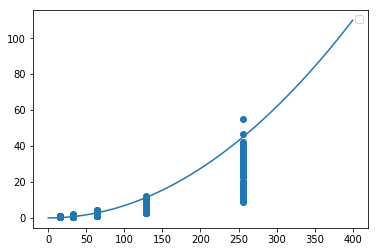

In [34]:
f, ax = plt.subplots()
ax.scatter(N_system, time)
x = np.linspace(0,400,400)
y = config['N_steps'] * x**2 * (11/400**2/1e4) 
ax.plot(x,y)
ax.legend()
time.sum() /60 /60

In [37]:
working_dir = Path('./really_long_classical_run')
incomplete = job_completion(working_dir)
print(f'incomplete jobs: {len(incomplete)}')

#for job_id in incomplete:
#    run_mcmc(job_id, working_dir)
#    print(f'Job {job_id} done')

incomplete jobs: 416


In [8]:
%%time
working_dir = Path('./classical_run')
gather_mcmc(working_dir, overwrite = True)

missing : 0 of 1000 total
CPU times: user 7.89 s, sys: 3.84 s, total: 11.7 s
Wall time: 1min 27s


['energies', 'magnetisations', 'numbers']
['N_system' 'beta' 'alpha']
2

/home/tch14/anaconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide



CPU times: user 1min 37s, sys: 48.7 s, total: 2min 26s
Wall time: 59.7 s


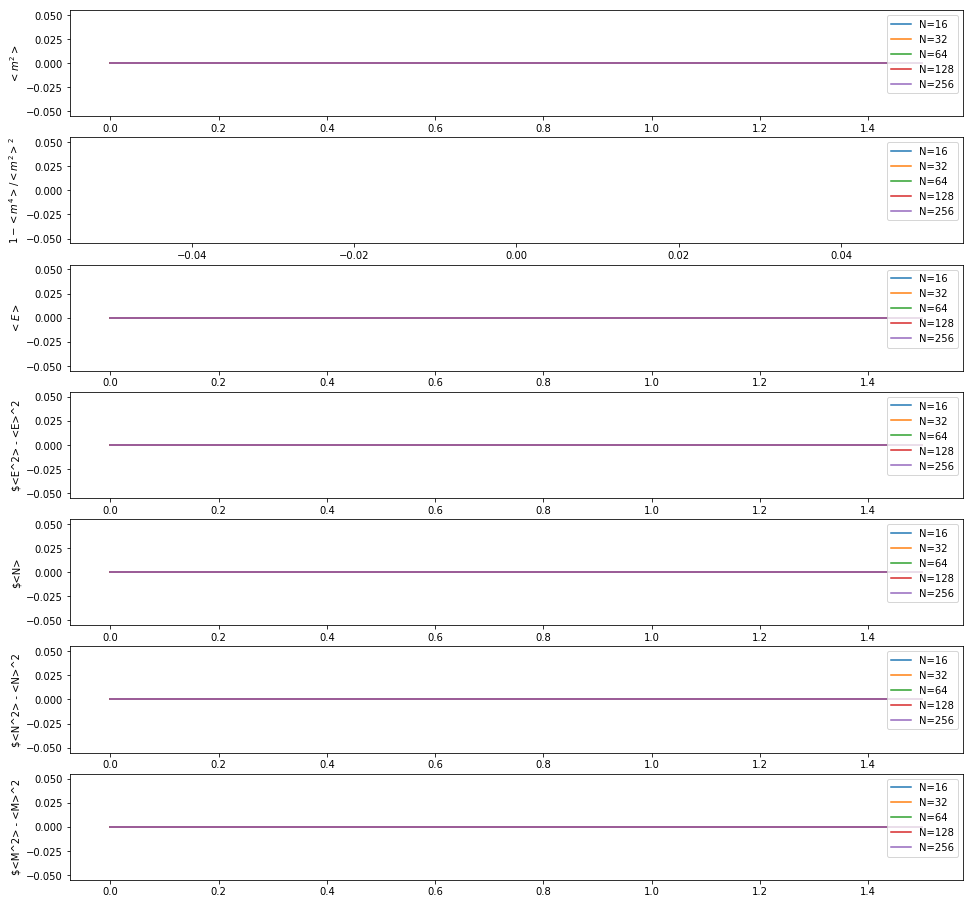

In [12]:
%%time
working_dir = Path('./really_long_classical_run')
result_filename = working_dir / 'results.hdf5'

with h5py.File(result_filename, 'r') as data:
    print(list(data.keys()))
    print(data.attrs['loop_over'])
    
    f, axs = plt.subplots(7, figsize = (16,16))
    

    N_systems = data.attrs['N_system']
    betas = data.attrs['beta']
    alphas = data.attrs['alpha']
    
    alpha_i = 2
    skip = 1000
    print(alpha_i)

    for i,N_system in enumerate(N_systems):
        #axes: N_system, beta, alpha, mcmc_step
        slic = (i, ..., alpha_i, slice(skip,None))
        
        e = data['energies'][slic] / N_system
        m = data['magnetisations'][slic] /  N_system
        n = data['numbers'][slic] /  N_system
        

        axs[0].plot(betas, (m**2).mean(axis=-1), label = f'N={N_system}')
        axs[0].set(ylabel = r'$<m^2>$')
        
        axs[1].plot(betas, 1-(m**4).mean(axis=-1)/(m**2).mean(axis=1)**2/3, label = f'N={N_system}')
        axs[1].set(ylabel = r'$1-<m^4>/<m^2>^2$')
        
        axs[2].plot(betas, e.mean(axis=-1), label = f'N={N_system}')
        axs[2].set(ylabel = r'$<E>$')
        axs[3].plot(betas, e.std(axis=-1), label = f'N={N_system}')
        axs[3].set(ylabel = r'$<E^2> - <E>^2')
        
        
        axs[4].plot(betas, n.mean(axis=-1), label = f'N={N_system}')
        axs[4].set(ylabel = r'$<N>')
        axs[5].plot(betas, n.std(axis=-1), label = f'N={N_system}')
        axs[5].set(ylabel = r'$<N^2> - <N>^2')
        
        axs[6].plot(betas, m.std(axis=-1), label = f'N={N_system}')
        axs[6].set(ylabel = r'$<M^2> - <M>^2')
        

    for a in axs: a.legend()
    

In [10]:
wdir = Path('./classical_run/logs')
def get_log(number, e_or_o = 'o'):
    filename = wdir / f'MCMC_simulation.{e_or_o}2124202.{number}'
    with open(filename, 'r') as f:
        output = f.read()
    return output.split('\n')
    
for n in job_completion(Path('./classical_run')):
    print(n, get_log(n)[1], get_log(n, 'e'))
    
#for n in range(1,100):
#    print(n, get_log(n)[1])

missing : 13 of 1000 total
898 Job is running on node cx1-138-3-4.cx1.hpc.ic.ac.uk ['/var/spool/PBS/mom_priv/jobs/2124202[898].cx1.SC: line 29: 22713 Illegal instruction     run_mcmc --job-id $PBS_ARRAY_INDEX --working-dir /rds/general/user/tch14/home/Falicok-Kimball-Monte-Carlo/classical_run', '']
899 Job is running on node cx1-138-3-4.cx1.hpc.ic.ac.uk ['/var/spool/PBS/mom_priv/jobs/2124202[899].cx1.SC: line 29: 22714 Illegal instruction     run_mcmc --job-id $PBS_ARRAY_INDEX --working-dir /rds/general/user/tch14/home/Falicok-Kimball-Monte-Carlo/classical_run', '']
900 Job is running on node cx1-138-3-4.cx1.hpc.ic.ac.uk ['/var/spool/PBS/mom_priv/jobs/2124202[900].cx1.SC: line 29: 22715 Illegal instruction     run_mcmc --job-id $PBS_ARRAY_INDEX --working-dir /rds/general/user/tch14/home/Falicok-Kimball-Monte-Carlo/classical_run', '']
901 Job is running on node cx1-138-4-1.cx1.hpc.ic.ac.uk ['/var/spool/PBS/mom_priv/jobs/2124202[901].cx1.SC: line 29: 29676 Illegal instruction     run_mcm

In [33]:
86509 / 60 / 60

24.030277777777776